# Приложение к диплому
Создание, обучение и анализ моделей

** Импортирование библиотек **

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(42)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
import pylab as plt
import mglearn

from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
%matplotlib inline

Using TensorFlow backend.


In [2]:
def learning_curve_model(X, Y, model, cv, train_sizes):
    """Функция строит кривую обучения"""
    plt.figure(figsize=(16, 10))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

def plot_keras_model(history):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    plt.figure(figsize=(10, 7))
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

class NullColumnsCleaner(BaseEstimator, TransformerMixin):
    """Трансформер, который убирает колонки, содержащий большое кол-во пустых значений"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        nulls = X.isnull().sum()
        nulls_keys = nulls[nulls > 50].keys()
        return X.drop(nulls_keys, axis=1).dropna()

## Чтение данных и первый взгляд

Первые пять строк данных

In [3]:
data = pd.read_excel('Data.xlsm')
data.head()

,"Stroke(AIS,TIA,AHS)",Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
0,AIS,1,1.0,0,0,0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0
1,AIS,1,3.0,0,0,0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0
2,AIS,0,5.0,0,0,0,0.0,1.0,1.0,2.0,...,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0
3,AIS,1,0.0,0,0,0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,0
4,AIS,1,13.0,0,0,0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# Краткое описание данных. Количество признаков, столбцов, типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 25 columns):
Stroke(AIS,TIA,AHS)    154 non-null object
Sex01                  154 non-null int64
StrokeAge              151 non-null float64
gFGB                   154 non-null int64
gF2                    154 non-null int64
gF5                    154 non-null int64
gF7VII                 148 non-null float64
gF13                   148 non-null float64
gITGA                  151 non-null float64
gITGB                  152 non-null float64
gPAI-1                 153 non-null float64
gMTR:2756A>G           148 non-null float64
gMTRR:66A>G            148 non-null float64
gMTHFR677СT            152 non-null float64
gMTHFR:1298A>C         148 non-null float64
gADD1 1378 G>T         71 non-null float64
gAGT T704C             72 non-null float64
gAGT C521T             72 non-null float64
gAGTR1 A 1166C         72 non-null float64
gAGTR2 G1675A          72 non-null float64
gCYP11B2 C344T         72 non

In [5]:
# Стандартное отклонение, среднее, персентели
data.describe()

,Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,gPAI-1,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
count,154.000000,151.000000,154.000000,154.000000,154.000000,148.000000,148.000000,151.000000,152.000000,153.000000,...,71.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,81.000000,81.000000,154.000000
mean,0.655844,3.350993,0.577922,0.045455,0.064935,0.162162,0.594595,0.880795,0.388158,1.176471,...,0.577465,0.958333,0.333333,0.486111,1.097222,1.125000,0.541667,1.074074,0.567901,0.474026
std,0.476642,4.650733,0.634338,0.208979,0.272373,0.421433,0.668411,0.692119,0.540411,0.708201,...,0.710372,0.700855,0.530745,0.581234,0.921721,0.710832,0.626583,0.720725,0.650736,0.500954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,4.500000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,1.000000,17.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


**Матрица корреляции**

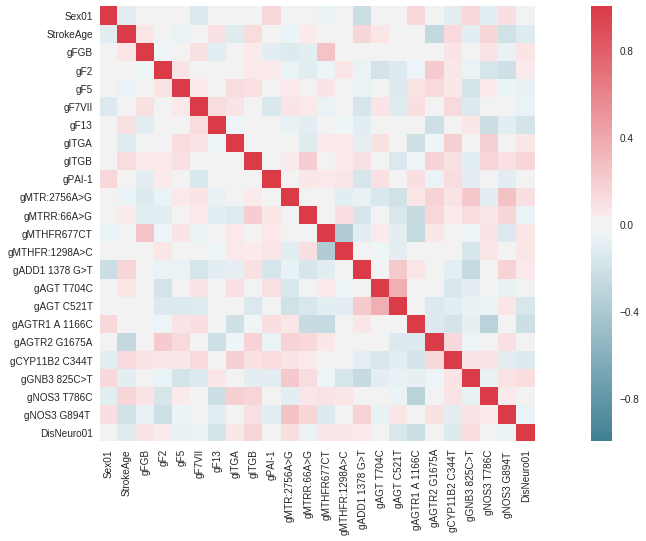

In [6]:
f, ax = plt.subplots(figsize=(20, 8))
corr = data.corr('spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [7]:
corr["DisNeuro01"].sort_values(ascending=False)

DisNeuro01        1.000000
gITGB             0.148790
gGNB3 825C>T      0.113762
gMTR:2756A>G      0.107731
gFGB              0.072636
gMTHFR:1298A>C    0.068079
gMTHFR677СT       0.065608
gITGA             0.059500
gADD1 1378 G>T    0.049230
gF2               0.042567
gNOS3 T786C       0.037769
gAGTR2 G1675A     0.018982
gAGT T704C       -0.022679
Sex01            -0.023996
gPAI-1           -0.028985
gNOS3 G894T      -0.065599
gMTRR:66A>G      -0.066198
gF7VII           -0.070085
gF5              -0.071265
StrokeAge        -0.119893
gCYP11B2 C344T   -0.127977
gAGT C521T       -0.156649
gF13             -0.179711
gAGTR1 A 1166C   -0.223450
Name: DisNeuro01, dtype: float64

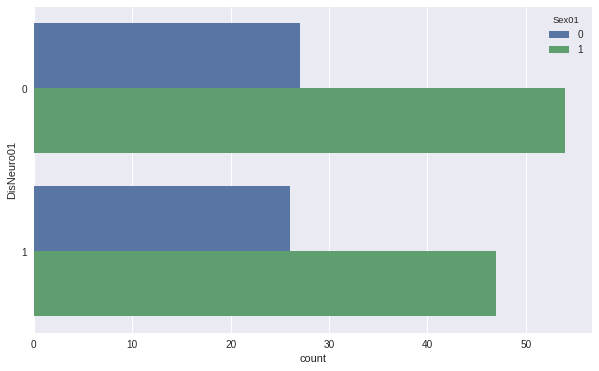

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(y="DisNeuro01", hue="Sex01", data=data)

** Предварительная подготовка данных. Отчистка и скалирование **

In [9]:
# Убираем колонки
data = NullColumnsCleaner().fit_transform(data).reset_index(drop=True)
# Разбиение на предикаторы и зависимум переменную
X = data.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y = data["DisNeuro01"].copy()

# Разбиваем стратифицировано данные на train и test выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Добавляем полиминальные признаки и скалируем данные std=1 и median=0, и 
prep_pipe = Pipeline([('poly_feature', PolynomialFeatures(interaction_only=True)), 
                      ('std_scaler', StandardScaler()),]).fit(X_train)
X_train_prep = prep_pipe.transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

**Логистическая регрессия**

Score:  0.739130434783 Test score:  0.620689655172 Best params:  {'C': 1, 'penalty': 'l1'}


<module 'pylab' from '/home/user/delete/myvenv/lib/python3.5/site-packages/pylab.py'>

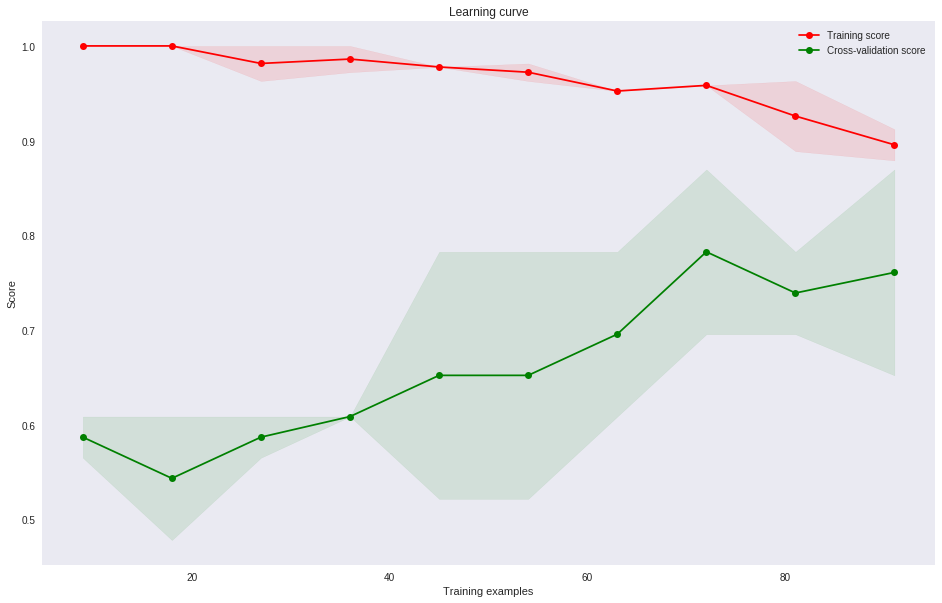

In [10]:
# Используем для подбора параметров кросс-валидацию
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
# Ищем наилучшие гиперпараметры для логистической регрессии(степень и уровнь регуляризации)
grid_search = GridSearchCV(LogisticRegression(), {"C": [0.001, 0.01, 0.1, 1, 3, 5, 10, 100, 500, 1000], "penalty": ["l2", "l1"]}, cv=cv)
grid_search.fit(X_train_prep, y_train)
log_reg = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", log_reg.score(X_test_prep, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(X_train_prep, y_train, log_reg, cv, np.linspace(0.1, 1.0, 10))

** Важность признаков. ** Коэффициенты логистической регрессии

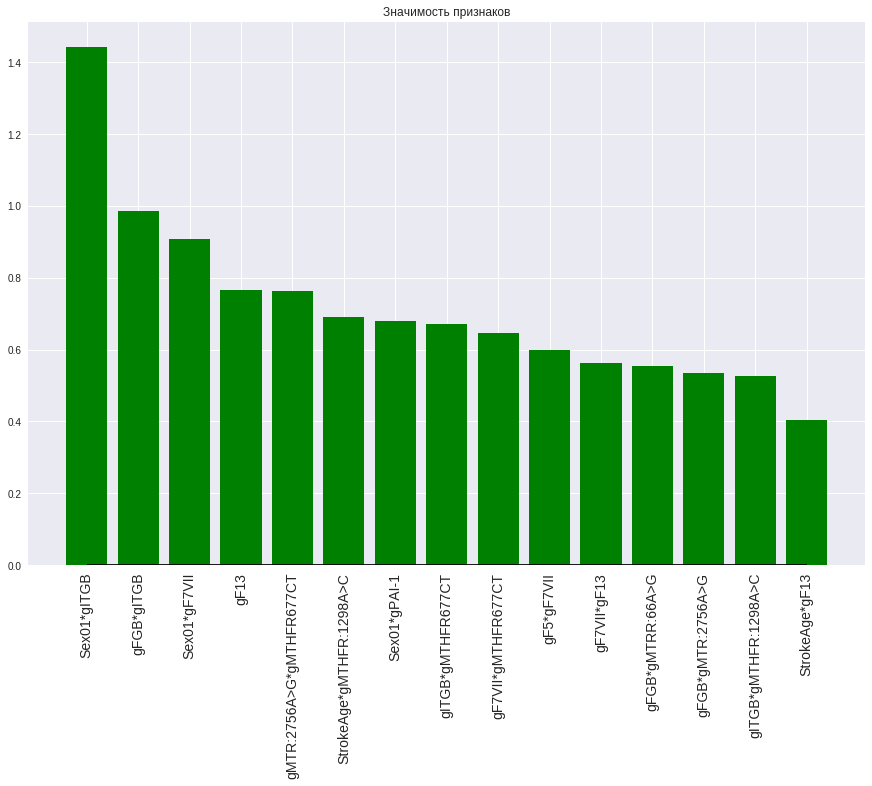

In [11]:
poly = PolynomialFeatures(interaction_only=True)
output_nparray = poly.fit_transform(X_train)
target_feature_names = ['*'.join(['{}'.format(pair[0]) for pair in tuple_ if pair[1]!=0]) for tuple_ in 
                        [zip(X.columns,p) for p in poly.powers_]]
importances = log_reg.coef_[0]
indices = np.argsort(np.abs(importances))[::-1]
FEATURE_COUNT = 15
target_feature_names_sorted = [target_feature_names[i] for i in indices[:FEATURE_COUNT]]
plt.figure(figsize=(15,10))
plt.title("Значимость признаков")
plt.bar(range(FEATURE_COUNT), np.abs(importances[indices[:FEATURE_COUNT]]),
       color="green", align="center")
plt.xticks(range(FEATURE_COUNT), target_feature_names_sorted, fontsize=14, rotation=90)
plt.hlines(0, 0, FEATURE_COUNT-1)

** Метрики модели(ошибки 1 и 2 рода, ROC-кривая) **

             precision    recall  f1-score   support

          0       0.64      0.60      0.62        15
          1       0.60      0.64      0.62        14

avg / total       0.62      0.62      0.62        29

F1 score:  0.620689655172
Roc_auc_score: 0.514285714286


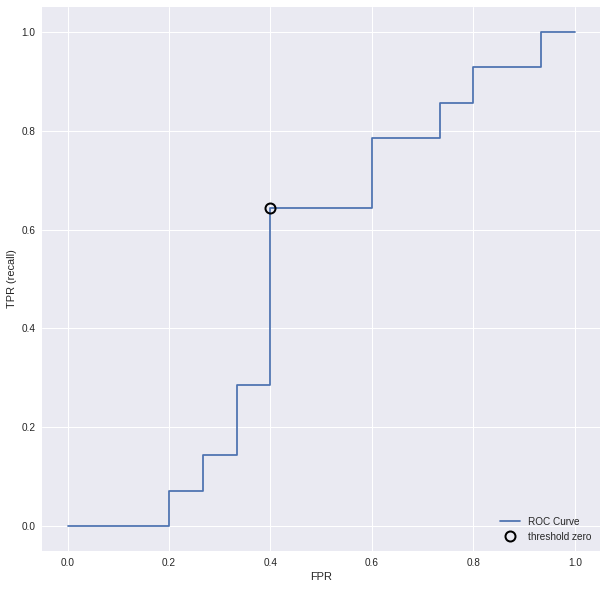

In [12]:
pred_x = X_test_prep
pred_y = y_test
pred_log_reg = log_reg.predict(pred_x)

confusion = confusion_matrix(pred_y, pred_log_reg)
print(classification_report(pred_y, pred_log_reg))
print("F1 score: ", f1_score(pred_y, pred_log_reg))
print("Roc_auc_score:", roc_auc_score(pred_y, log_reg.decision_function(pred_x)))
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(pred_y, log_reg.decision_function(pred_x))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

Score:  0.565217391304 Test score:  0.51724137931 Best params:  {'C': 1, 'penalty': 'l2'}


<module 'pylab' from '/home/user/delete/myvenv/lib/python3.5/site-packages/pylab.py'>

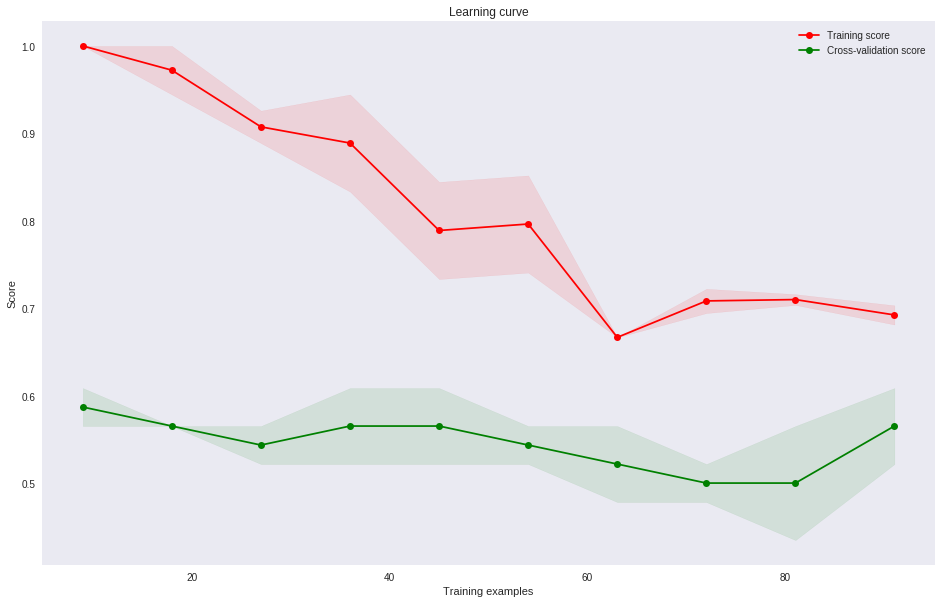

In [13]:
train_new_feature = pd.DataFrame(X_train_prep, columns=target_feature_names)
test_new_feature = pd.DataFrame(X_test_prep, columns=target_feature_names)
column_ = target_feature_names[16:]
train_new_feature = train_new_feature.drop(column_, axis=1)
test_new_feature = test_new_feature.drop(column_, axis=1)
grid_search = GridSearchCV(LogisticRegression(), {"C": [0.001, 0.01, 0.1, 1, 3, 5, 10, 100, 500, 1000], "penalty": ["l2", "l1"]}, cv=cv)
grid_search.fit(train_new_feature, y_train)
log_reg_new = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", log_reg_new.score(test_new_feature, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(train_new_feature, y_train, log_reg_new, cv, np.linspace(0.1, 1.0, 10))

## Искусственная нейронная сеть

Подготовка данных. Скалирование. Добавление признаков вплоть до 3 степени. Отберем признаки линейной SVM.

In [14]:
prep_pipe = Pipeline([('std', StandardScaler()), ('poly_feature', PolynomialFeatures(degree=3, interaction_only=True)), ]).fit(X_train)
X_train_prep = prep_pipe.transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

lsvc = LinearSVC(C=10, penalty="l1", dual=False, random_state=42).fit(X_train_prep, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_tr = model.transform(X_train_prep)
X_te = model.transform(X_test_prep)
X_tr.shape

(114, 95)

Score:  0.819047619048 Test score:  0.724137931034 Best params:  {'hidden_layer_sizes': 6, 'alpha': 0.01}


<module 'pylab' from '/home/user/delete/myvenv/lib/python3.5/site-packages/pylab.py'>

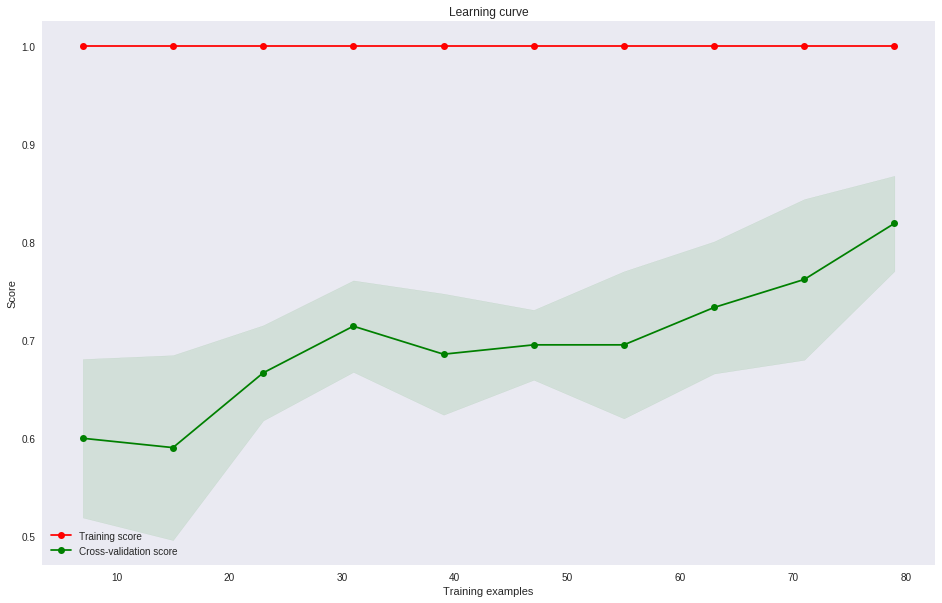

In [15]:
# Подбор параметров нейронной сети
param_grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 0.3, 3, 5], "hidden_layer_sizes": [(neuro_count) for neuro_count in range(1, 100, 5)]}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
#cv = KFold(n_splits=4, random_state=42)
grid_search = GridSearchCV(MLPClassifier(random_state=42, solver='lbfgs'), param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_tr, y_train)
nn = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", nn.score(X_te, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(X_tr, y_train, nn, cv, np.linspace(0.1, 1.0, 10))

Epoch 00995: early stopping
29/29 [==============================] - 0s
[1.4501771926879883, 0.79310345649719238]


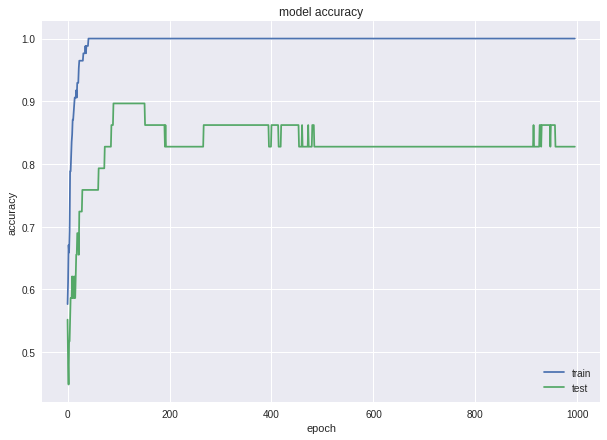

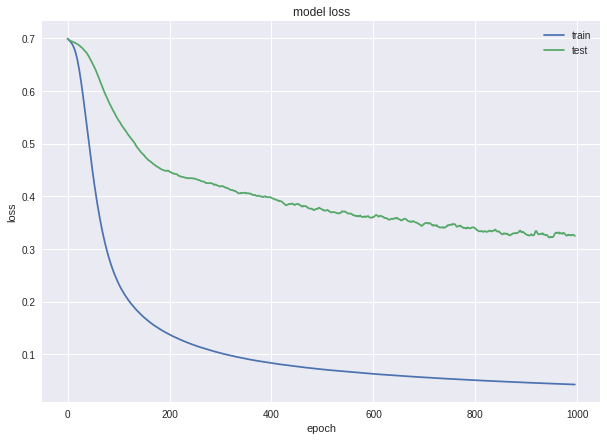

In [19]:
model = Sequential()
es = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
model.add(Dense(6, input_dim=X_tr.shape[1], activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001), kernel_initializer='uniform'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history = model.fit(X_tr, y_train.values.reshape(-1, 1), callbacks=[es], epochs=1500, validation_split=0.25, verbose=0)
print(model.evaluate(X_te, y_test.values))
plot_keras_model(history)

 32/114 [=======>......................] - ETA: 0s
             precision    recall  f1-score   support

          0       0.97      0.95      0.96        60
          1       0.95      0.96      0.95        54

avg / total       0.96      0.96      0.96       114

F1 score:  0.954128440367
Roc_auc_score: 0.956481481481


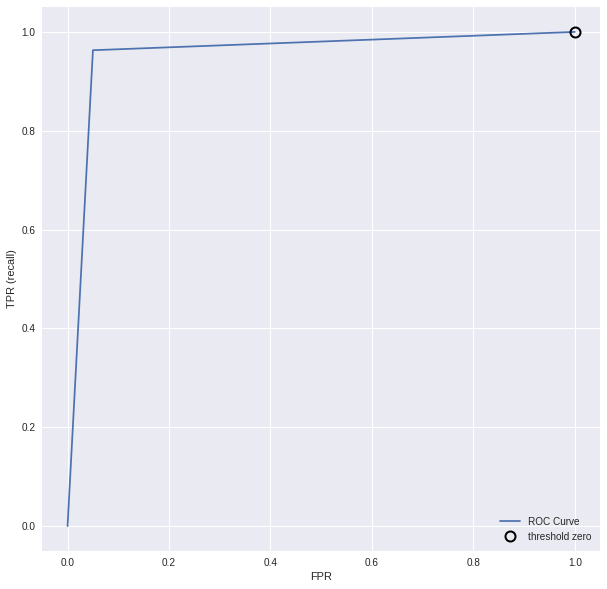

In [22]:
pred_x = X_tr
pred_y = y_train
pred_log_reg = model.predict_classes(pred_x)

confusion = confusion_matrix(pred_y, pred_log_reg)
print()
print(classification_report(pred_y, pred_log_reg))
print("F1 score: ", f1_score(pred_y, pred_log_reg))
print("Roc_auc_score:", roc_auc_score(pred_y, pred_log_reg))
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(pred_y, pred_log_reg)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)